In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [2]:
df = pd.read_csv('data/data/daily_min_temp.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
df = df.resample('W').mean()

<Axes: xlabel='Date'>

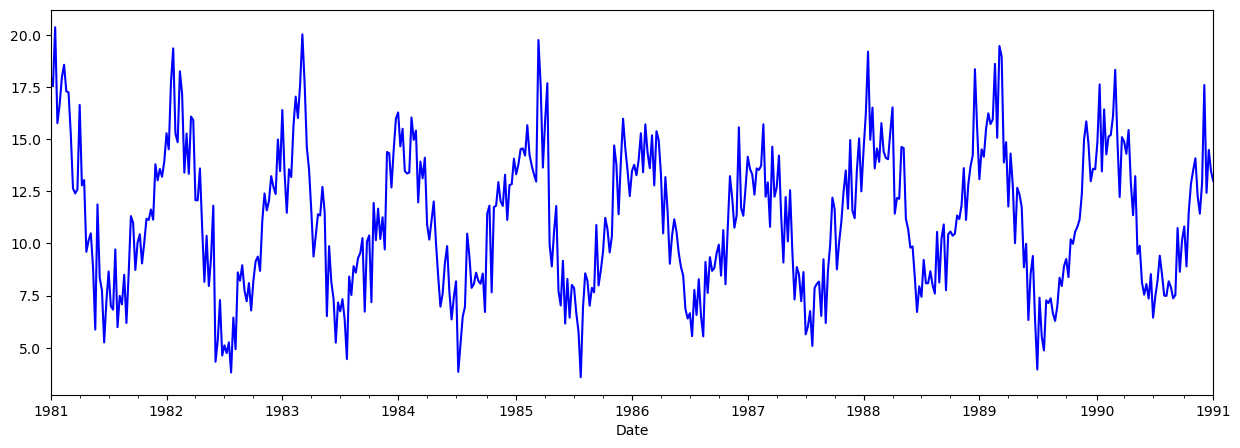

In [4]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [5]:
from sklearn.model_selection import train_test_split

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Dataloader

In [12]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

bs = 16
seq_len = 21

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (19, 21, 1)
Note: last 18 data excluded

(N, S, F): (4, 21, 1)
Note: last 20 data excluded



# Arsitektur & Config

In [13]:
from jcopdl.layers import linear_block

class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)

        return x, hidden

In [31]:
train_set.n_feature

1

In [14]:
config = set_config({
    'input_size': train_set.n_feature,
    'output_size': 1,
    'hidden_size': 64, 
    'num_layers': 3,
    'dropout': 0,
    'seq_len': train_set.n_seq
})

# Training Preparatioon -> MCOC

In [15]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
callback = Callback(model, config, outdir='model/gru')

# Training

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0

    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]

    cost = cost / len(dataset)

    return cost

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 134.8007 | Test_cost  = 136.9142 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 125.8342 | Test_cost  = 127.5339 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 116.7060 | Test_cost  = 117.8593 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 107.2758 | Test_cost  = 107.9803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 97.6668 | Test_cost  = 98.3355 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 88.3437 | Test_cost  = 89.5063 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 79.8785 | Test_cost  = 81.8771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 72.6278 | Test_cost  = 75.5356 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 66.6508 | Test_cost  = 70.3479 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 61.7944 | Test_cost  = 66.0793 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 57.8172 | Test_cost  = 62.4910 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 54.4828 | Test_cost  = 59.3900 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 51.6052 | Test_cost  = 56.6397 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 49.0548 | Test_cost  = 54.1499 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 46.7469 | Test_cost  = 51.8628 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 44.6280 | Test_cost  = 49.7410 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 42.6633 | Test_cost  = 47.7587 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 40.8290 | Test_cost  = 45.8968 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 39.1076 | Test_cost  = 44.1412 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 37.4860 | Test_cost  = 42.4808 | 


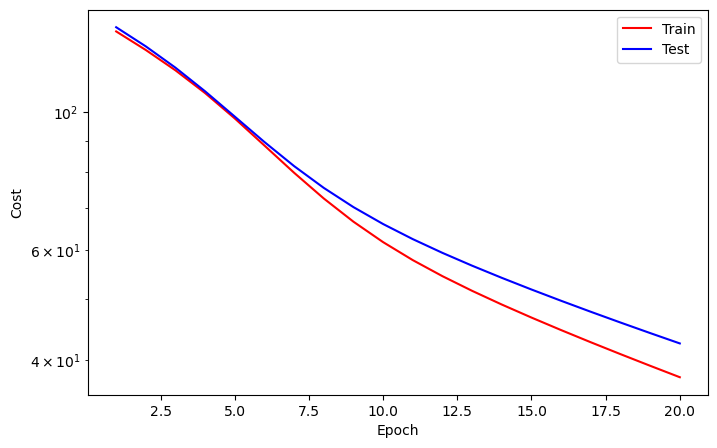

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 35.9543 | Test_cost  = 40.9075 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 34.5051 | Test_cost  = 39.4148 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 33.1324 | Test_cost  = 37.9977 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 31.8317 | Test_cost  = 36.6519 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 30.5990 | Test_cost  = 35.3736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 29.4306 | Test_cost  = 34.1595 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 28.3235 | Test_cost  = 33.0063 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 27.2747 | Test_cost  = 31.9116 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 26.2816 | Test_cost  = 30.8726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 25.3418 | Test_cost  = 29.8870 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 24.4529 | Test_cost  = 28.9525 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 23.6127 | Test_cost  = 28.0670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 22.8192 | Test_cost  = 27.2285 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 22.0702 | Test_cost  = 26.4347 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 21.3638 | Test_cost  = 25.6839 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 20.6980 | Test_cost  = 24.9741 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 20.0710 | Test_cost  = 24.3034 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 19.4810 | Test_cost  = 23.6701 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 18.9261 | Test_cost  = 23.0725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 18.4048 | Test_cost  = 22.5087 | 


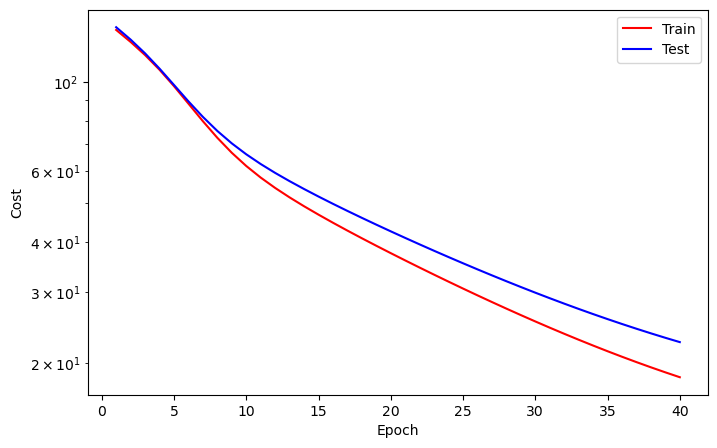

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 17.9152 | Test_cost  = 21.9773 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 17.4559 | Test_cost  = 21.4767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 17.0253 | Test_cost  = 21.0053 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 16.6220 | Test_cost  = 20.5617 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 16.2444 | Test_cost  = 20.1445 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 15.8913 | Test_cost  = 19.7523 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 15.5613 | Test_cost  = 19.3839 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 15.2532 | Test_cost  = 19.0379 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 14.9657 | Test_cost  = 18.7133 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 14.6977 | Test_cost  = 18.4089 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 14.4481 | Test_cost  = 18.1235 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 14.2158 | Test_cost  = 17.8561 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 13.9998 | Test_cost  = 17.6057 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 13.7992 | Test_cost  = 17.3714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 13.6129 | Test_cost  = 17.1523 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 13.4402 | Test_cost  = 16.9474 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 13.2802 | Test_cost  = 16.7559 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 13.1321 | Test_cost  = 16.5771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 12.9951 | Test_cost  = 16.4102 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 12.8685 | Test_cost  = 16.2544 | 


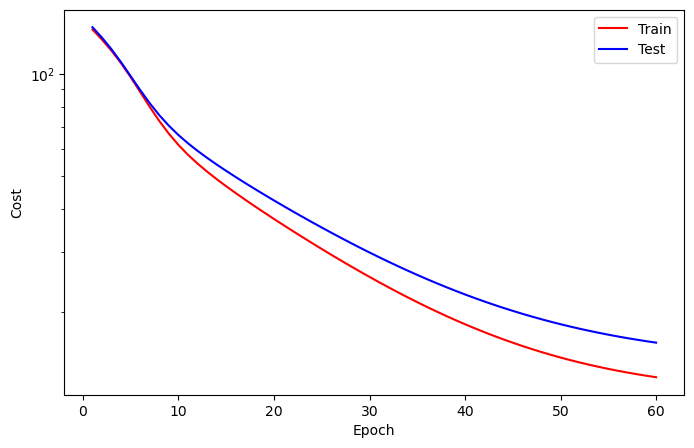

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 12.7517 | Test_cost  = 16.1092 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 12.6439 | Test_cost  = 15.9737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 12.5446 | Test_cost  = 15.8475 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 12.4532 | Test_cost  = 15.7300 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 12.3692 | Test_cost  = 15.6206 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 12.2919 | Test_cost  = 15.5187 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 12.2210 | Test_cost  = 15.4240 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 12.1560 | Test_cost  = 15.3358 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 12.0965 | Test_cost  = 15.2539 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 12.0419 | Test_cost  = 15.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 11.9921 | Test_cost  = 15.1069 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 11.9465 | Test_cost  = 15.0412 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 11.9050 | Test_cost  = 14.9801 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 11.8671 | Test_cost  = 14.9234 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 11.8325 | Test_cost  = 14.8707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 11.8011 | Test_cost  = 14.8218 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.7725 | Test_cost  = 14.7764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.7465 | Test_cost  = 14.7343 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.7230 | Test_cost  = 14.6953 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.7016 | Test_cost  = 14.6590 | 


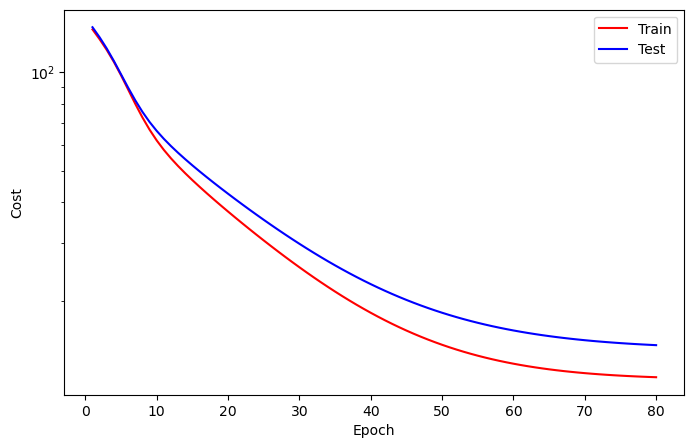

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 11.6822 | Test_cost  = 14.6254 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 11.6647 | Test_cost  = 14.5941 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 11.6488 | Test_cost  = 14.5652 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 11.6345 | Test_cost  = 14.5383 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 11.6215 | Test_cost  = 14.5134 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 11.6098 | Test_cost  = 14.4903 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 11.5993 | Test_cost  = 14.4688 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 11.5898 | Test_cost  = 14.4489 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 11.5812 | Test_cost  = 14.4304 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 11.5735 | Test_cost  = 14.4132 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 11.5666 | Test_cost  = 14.3973 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 11.5604 | Test_cost  = 14.3825 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 11.5548 | Test_cost  = 14.3688 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 11.5498 | Test_cost  = 14.3560 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 11.5452 | Test_cost  = 14.3442 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 11.5412 | Test_cost  = 14.3331 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 11.5376 | Test_cost  = 14.3229 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 11.5343 | Test_cost  = 14.3134 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 11.5314 | Test_cost  = 14.3046 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 11.5288 | Test_cost  = 14.2964 | 


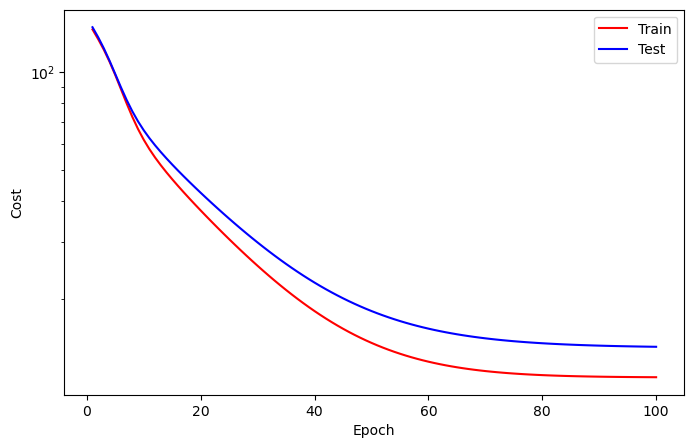

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.5264 | Test_cost  = 14.2888 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.5243 | Test_cost  = 14.2817 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.5224 | Test_cost  = 14.2751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.5207 | Test_cost  = 14.2690 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.5192 | Test_cost  = 14.2633 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.5178 | Test_cost  = 14.2580 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.5165 | Test_cost  = 14.2531 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.5154 | Test_cost  = 14.2485 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.5144 | Test_cost  = 14.2442 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.5135 | Test_cost  = 14.2403 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.5127 | Test_cost  = 14.2366 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 11.5119 | Test_cost  = 14.2332 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 11.5113 | Test_cost  = 14.2300 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 11.5106 | Test_cost  = 14.2270 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 11.5101 | Test_cost  = 14.2242 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 11.5096 | Test_cost  = 14.2217 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 11.5091 | Test_cost  = 14.2193 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 11.5087 | Test_cost  = 14.2171 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 11.5083 | Test_cost  = 14.2150 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 11.5079 | Test_cost  = 14.2131 | 


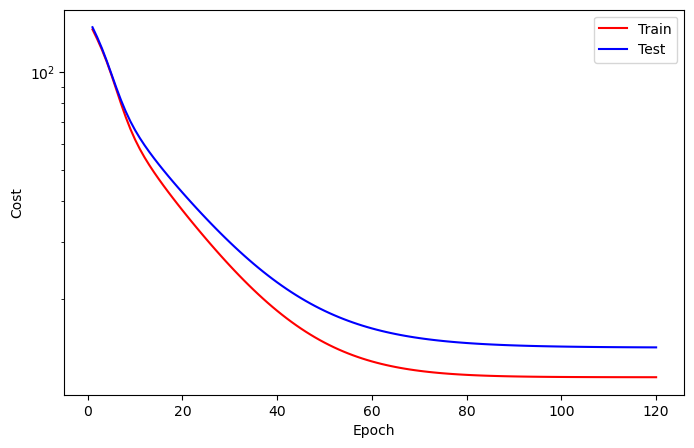

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 11.5076 | Test_cost  = 14.2113 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 11.5072 | Test_cost  = 14.2096 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 11.5069 | Test_cost  = 14.2081 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 11.5067 | Test_cost  = 14.2067 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 11.5064 | Test_cost  = 14.2053 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 11.5062 | Test_cost  = 14.2041 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 11.5059 | Test_cost  = 14.2029 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 11.5057 | Test_cost  = 14.2018 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 11.5055 | Test_cost  = 14.2008 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 11.5053 | Test_cost  = 14.1999 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 11.5051 | Test_cost  = 14.1990 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 11.5049 | Test_cost  = 14.1982 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 11.5047 | Test_cost  = 14.1975 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 11.5046 | Test_cost  = 14.1968 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 11.5044 | Test_cost  = 14.1961 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 11.5042 | Test_cost  = 14.1955 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 11.5041 | Test_cost  = 14.1949 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 11.5039 | Test_cost  = 14.1944 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 11.5038 | Test_cost  = 14.1939 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 11.5036 | Test_cost  = 14.1934 | 


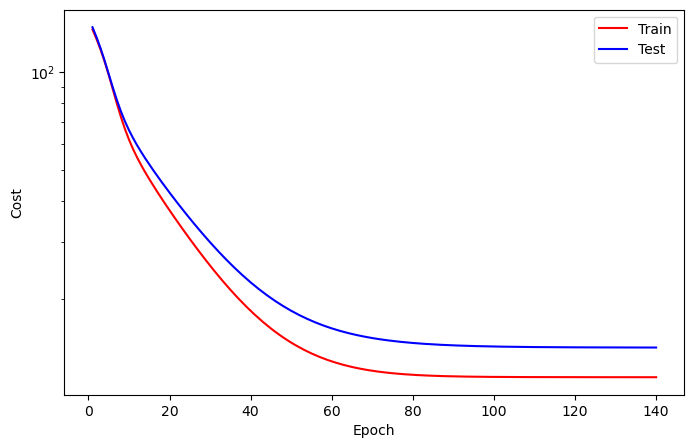

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 11.5035 | Test_cost  = 14.1930 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 11.5033 | Test_cost  = 14.1926 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 11.5032 | Test_cost  = 14.1922 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 11.5031 | Test_cost  = 14.1918 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 11.5029 | Test_cost  = 14.1915 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 11.5028 | Test_cost  = 14.1912 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 11.5027 | Test_cost  = 14.1909 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 11.5025 | Test_cost  = 14.1906 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 11.5024 | Test_cost  = 14.1903 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 11.5023 | Test_cost  = 14.1900 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 11.5022 | Test_cost  = 14.1898 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 11.5020 | Test_cost  = 14.1896 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 11.5019 | Test_cost  = 14.1893 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 11.5018 | Test_cost  = 14.1891 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 11.5017 | Test_cost  = 14.1889 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 11.5015 | Test_cost  = 14.1887 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 11.5014 | Test_cost  = 14.1885 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 11.5013 | Test_cost  = 14.1884 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 11.5012 | Test_cost  = 14.1882 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 11.5011 | Test_cost  = 14.1880 | 


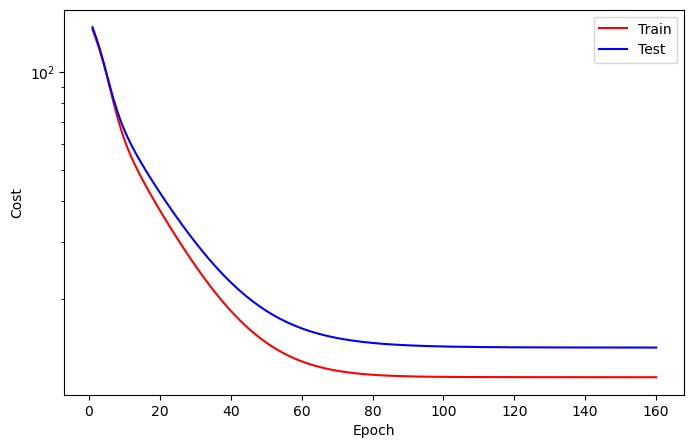

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 11.5009 | Test_cost  = 14.1878 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 11.5008 | Test_cost  = 14.1877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 11.5007 | Test_cost  = 14.1875 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 11.5006 | Test_cost  = 14.1874 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 11.5005 | Test_cost  = 14.1872 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 11.5003 | Test_cost  = 14.1871 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 11.5002 | Test_cost  = 14.1870 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 11.5001 | Test_cost  = 14.1868 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 11.5000 | Test_cost  = 14.1867 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 11.4999 | Test_cost  = 14.1865 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 11.4997 | Test_cost  = 14.1864 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 11.4996 | Test_cost  = 14.1863 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 11.4995 | Test_cost  = 14.1862 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 11.4994 | Test_cost  = 14.1860 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 11.4993 | Test_cost  = 14.1859 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 11.4991 | Test_cost  = 14.1858 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 11.4990 | Test_cost  = 14.1857 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 11.4989 | Test_cost  = 14.1856 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 11.4988 | Test_cost  = 14.1854 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 11.4987 | Test_cost  = 14.1853 | 


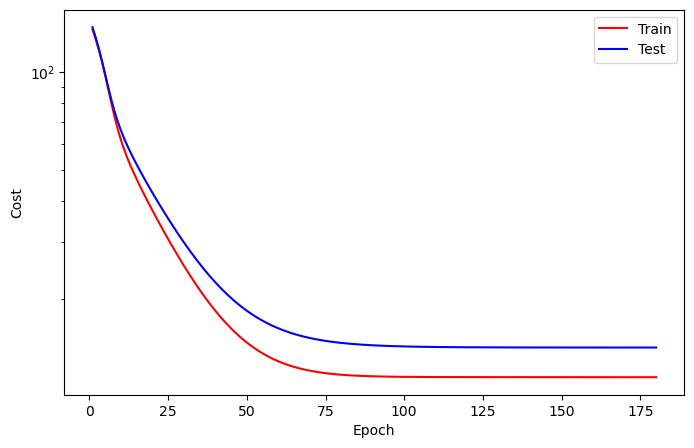

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 11.4985 | Test_cost  = 14.1852 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 11.4984 | Test_cost  = 14.1851 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 11.4983 | Test_cost  = 14.1850 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 11.4982 | Test_cost  = 14.1849 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 11.4981 | Test_cost  = 14.1848 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 11.4979 | Test_cost  = 14.1846 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 11.4978 | Test_cost  = 14.1845 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 11.4977 | Test_cost  = 14.1844 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 11.4976 | Test_cost  = 14.1843 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 11.4974 | Test_cost  = 14.1842 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 11.4973 | Test_cost  = 14.1841 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 11.4972 | Test_cost  = 14.1840 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 11.4971 | Test_cost  = 14.1839 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 11.4970 | Test_cost  = 14.1838 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 11.4968 | Test_cost  = 14.1837 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 11.4967 | Test_cost  = 14.1836 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 11.4966 | Test_cost  = 14.1835 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 11.4965 | Test_cost  = 14.1834 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 11.4963 | Test_cost  = 14.1833 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 11.4962 | Test_cost  = 14.1832 | 


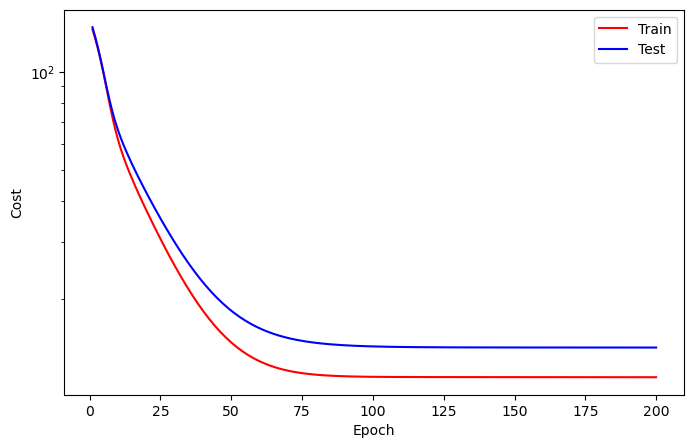

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 11.4961 | Test_cost  = 14.1831 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 11.4960 | Test_cost  = 14.1830 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 11.4958 | Test_cost  = 14.1829 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 11.4957 | Test_cost  = 14.1828 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 11.4956 | Test_cost  = 14.1827 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 11.4955 | Test_cost  = 14.1826 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 11.4953 | Test_cost  = 14.1825 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 11.4952 | Test_cost  = 14.1824 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 11.4951 | Test_cost  = 14.1823 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 11.4949 | Test_cost  = 14.1822 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 11.4948 | Test_cost  = 14.1822 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 11.4947 | Test_cost  = 14.1821 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 11.4946 | Test_cost  = 14.1820 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 11.4944 | Test_cost  = 14.1819 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 11.4943 | Test_cost  = 14.1818 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 11.4942 | Test_cost  = 14.1817 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 11.4940 | Test_cost  = 14.1816 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 11.4939 | Test_cost  = 14.1815 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 11.4938 | Test_cost  = 14.1815 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 11.4936 | Test_cost  = 14.1814 | 


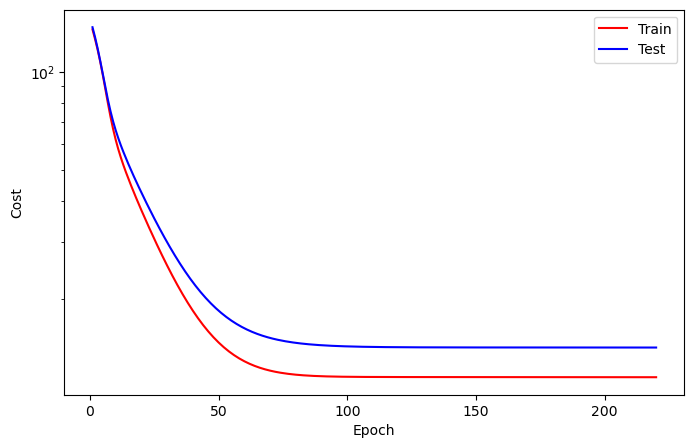

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 11.4935 | Test_cost  = 14.1813 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 11.4934 | Test_cost  = 14.1812 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 11.4932 | Test_cost  = 14.1811 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 11.4931 | Test_cost  = 14.1810 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 11.4930 | Test_cost  = 14.1810 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 11.4929 | Test_cost  = 14.1809 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 11.4927 | Test_cost  = 14.1808 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 11.4926 | Test_cost  = 14.1807 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 11.4924 | Test_cost  = 14.1807 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 11.4923 | Test_cost  = 14.1806 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 11.4922 | Test_cost  = 14.1805 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 11.4920 | Test_cost  = 14.1804 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 11.4919 | Test_cost  = 14.1804 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 11.4918 | Test_cost  = 14.1803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 11.4916 | Test_cost  = 14.1802 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 11.4915 | Test_cost  = 14.1801 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 11.4914 | Test_cost  = 14.1801 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 11.4912 | Test_cost  = 14.1800 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 11.4911 | Test_cost  = 14.1799 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 11.4909 | Test_cost  = 14.1799 | 


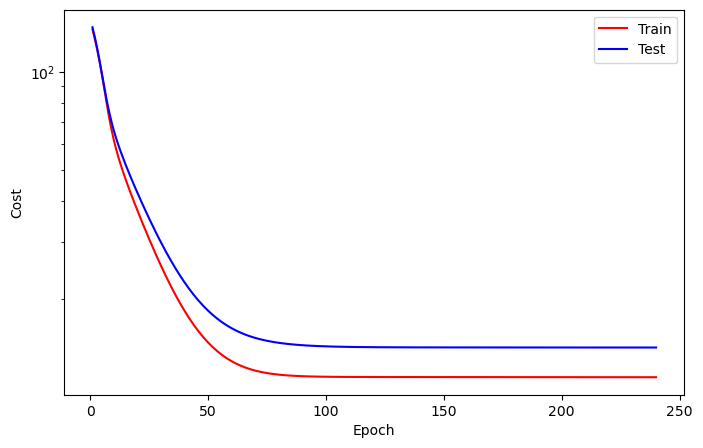

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 11.4908 | Test_cost  = 14.1798 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 11.4907 | Test_cost  = 14.1797 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 11.4905 | Test_cost  = 14.1796 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 11.4904 | Test_cost  = 14.1796 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 11.4902 | Test_cost  = 14.1795 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 11.4901 | Test_cost  = 14.1795 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 11.4900 | Test_cost  = 14.1794 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 11.4898 | Test_cost  = 14.1793 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 11.4897 | Test_cost  = 14.1793 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 11.4895 | Test_cost  = 14.1792 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 11.4894 | Test_cost  = 14.1791 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 11.4893 | Test_cost  = 14.1791 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 11.4891 | Test_cost  = 14.1790 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 11.4890 | Test_cost  = 14.1790 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 11.4888 | Test_cost  = 14.1789 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 11.4887 | Test_cost  = 14.1788 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 11.4885 | Test_cost  = 14.1788 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 11.4884 | Test_cost  = 14.1787 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 11.4882 | Test_cost  = 14.1787 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 11.4881 | Test_cost  = 14.1786 | 


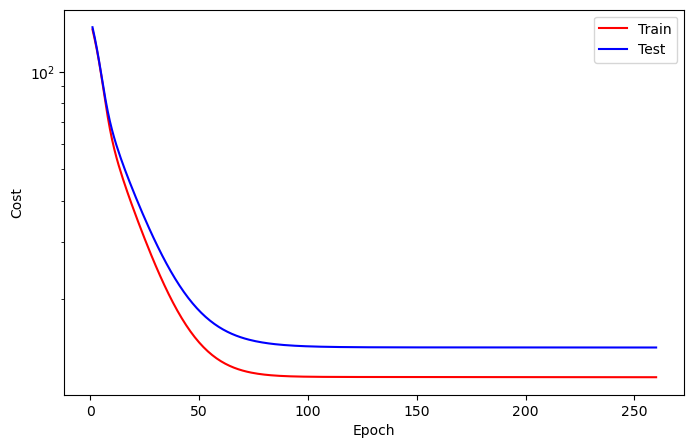

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 11.4879 | Test_cost  = 14.1786 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 11.4878 | Test_cost  = 14.1785 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 11.4877 | Test_cost  = 14.1784 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 11.4875 | Test_cost  = 14.1784 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 11.4874 | Test_cost  = 14.1783 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 11.4872 | Test_cost  = 14.1783 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 11.4871 | Test_cost  = 14.1782 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 11.4869 | Test_cost  = 14.1782 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 11.4868 | Test_cost  = 14.1781 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 11.4866 | Test_cost  = 14.1781 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 11.4865 | Test_cost  = 14.1780 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 11.4863 | Test_cost  = 14.1780 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 11.4861 | Test_cost  = 14.1779 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 11.4860 | Test_cost  = 14.1779 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 11.4858 | Test_cost  = 14.1778 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 11.4857 | Test_cost  = 14.1778 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 11.4855 | Test_cost  = 14.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 11.4854 | Test_cost  = 14.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 11.4852 | Test_cost  = 14.1776 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 11.4851 | Test_cost  = 14.1776 | 


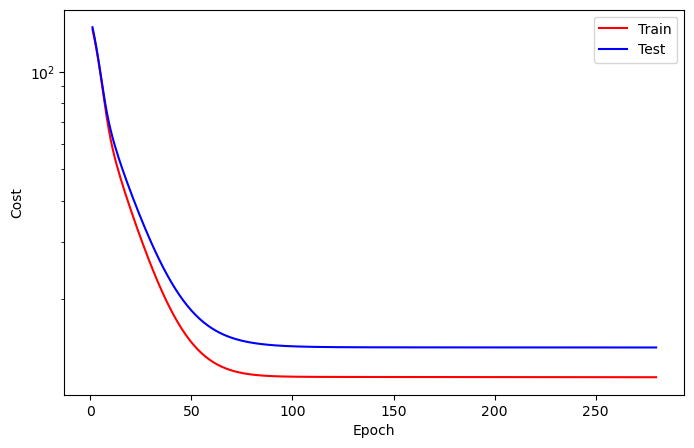

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 11.4849 | Test_cost  = 14.1776 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 11.4848 | Test_cost  = 14.1775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 11.4846 | Test_cost  = 14.1775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 11.4844 | Test_cost  = 14.1774 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 11.4843 | Test_cost  = 14.1774 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 11.4841 | Test_cost  = 14.1773 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 11.4840 | Test_cost  = 14.1773 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 11.4838 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 11.4836 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 11.4835 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 11.4833 | Test_cost  = 14.1771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 11.4832 | Test_cost  = 14.1771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 11.4830 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 11.4828 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 11.4827 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 11.4825 | Test_cost  = 14.1769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 11.4823 | Test_cost  = 14.1769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 11.4822 | Test_cost  = 14.1768 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 11.4820 | Test_cost  = 14.1768 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 11.4818 | Test_cost  = 14.1768 | 


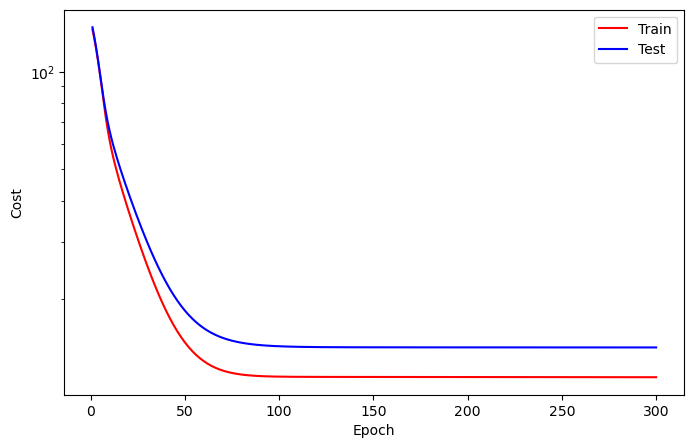

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 11.4817 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 11.4815 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 11.4813 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 11.4812 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 11.4810 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 11.4808 | Test_cost  = 14.1765 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 11.4807 | Test_cost  = 14.1765 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 11.4805 | Test_cost  = 14.1764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 11.4803 | Test_cost  = 14.1764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 11.4801 | Test_cost  = 14.1764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 11.4800 | Test_cost  = 14.1763 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 11.4798 | Test_cost  = 14.1763 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 11.4796 | Test_cost  = 14.1762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 11.4794 | Test_cost  = 14.1762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 11.4793 | Test_cost  = 14.1762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 11.4791 | Test_cost  = 14.1761 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 11.4789 | Test_cost  = 14.1761 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 11.4787 | Test_cost  = 14.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 11.4786 | Test_cost  = 14.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 11.4784 | Test_cost  = 14.1760 | 


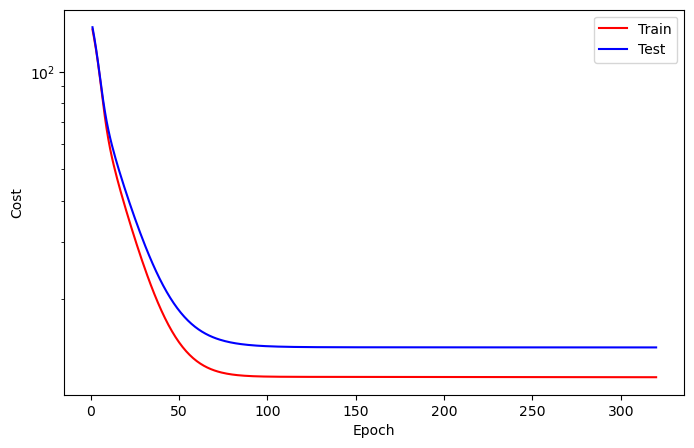

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 11.4782 | Test_cost  = 14.1759 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 11.4780 | Test_cost  = 14.1759 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 11.4778 | Test_cost  = 14.1758 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 11.4777 | Test_cost  = 14.1758 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 11.4775 | Test_cost  = 14.1758 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 11.4773 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 11.4771 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 11.4769 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 11.4768 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 11.4766 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 11.4764 | Test_cost  = 14.1755 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 11.4762 | Test_cost  = 14.1755 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 11.4760 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 11.4758 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 11.4756 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 11.4754 | Test_cost  = 14.1753 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 11.4753 | Test_cost  = 14.1753 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 11.4751 | Test_cost  = 14.1752 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 11.4749 | Test_cost  = 14.1752 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 11.4747 | Test_cost  = 14.1752 | 


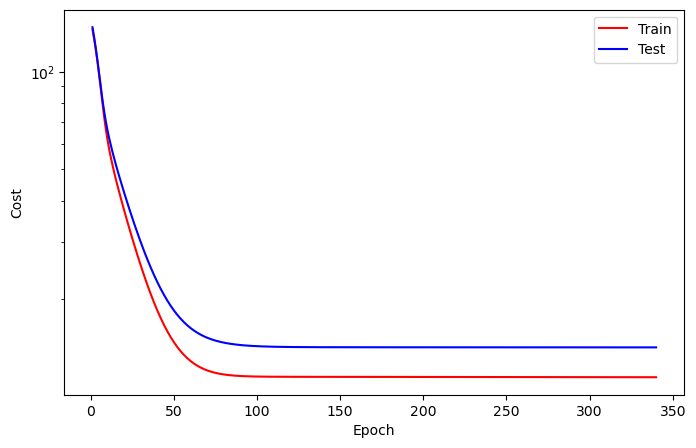

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 11.4745 | Test_cost  = 14.1751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 11.4743 | Test_cost  = 14.1751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 11.4741 | Test_cost  = 14.1750 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 11.4739 | Test_cost  = 14.1750 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 11.4737 | Test_cost  = 14.1749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 11.4735 | Test_cost  = 14.1749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 11.4733 | Test_cost  = 14.1748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 11.4731 | Test_cost  = 14.1748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 11.4729 | Test_cost  = 14.1748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 11.4727 | Test_cost  = 14.1747 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 11.4725 | Test_cost  = 14.1747 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 11.4723 | Test_cost  = 14.1746 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 11.4721 | Test_cost  = 14.1746 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 11.4719 | Test_cost  = 14.1745 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 11.4717 | Test_cost  = 14.1745 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 11.4715 | Test_cost  = 14.1744 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 11.4713 | Test_cost  = 14.1744 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 11.4711 | Test_cost  = 14.1743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 11.4709 | Test_cost  = 14.1743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 11.4707 | Test_cost  = 14.1742 | 


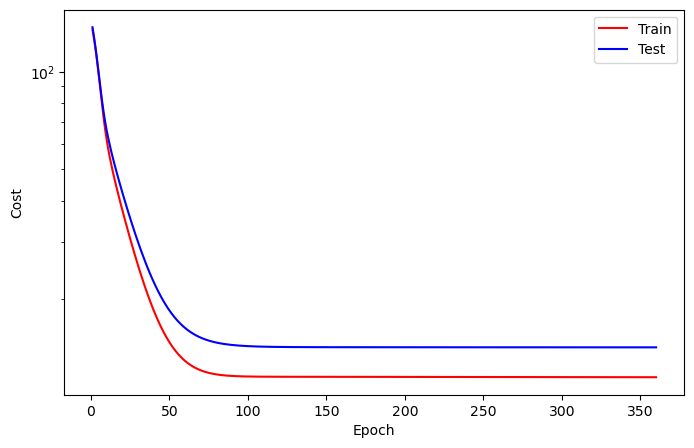

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 11.4704 | Test_cost  = 14.1742 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 11.4702 | Test_cost  = 14.1741 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 11.4700 | Test_cost  = 14.1741 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 11.4698 | Test_cost  = 14.1740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 11.4696 | Test_cost  = 14.1740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 11.4694 | Test_cost  = 14.1739 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 11.4692 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 11.4689 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 11.4687 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 11.4685 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 11.4683 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 11.4680 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 11.4678 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 11.4676 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   375
Train_cost  = 11.4674 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   376
Train_cost  = 11.4671 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   377
Train_cost  = 11.4669 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   378
Train_cost  = 11.4666 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   379
Train_cost  = 11.4664 | Test_cost  = 14.1731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   380
Train_cost  = 11.4662 | Test_cost  = 14.1730 | 


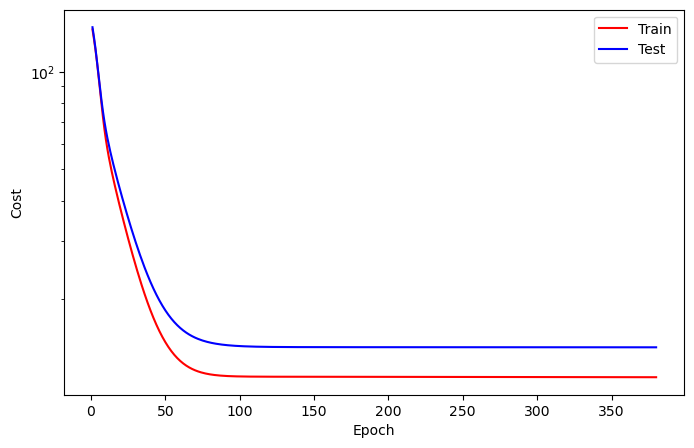

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   381
Train_cost  = 11.4659 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   382
Train_cost  = 11.4657 | Test_cost  = 14.1729 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 11.4654 | Test_cost  = 14.1728 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 11.4652 | Test_cost  = 14.1728 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 11.4649 | Test_cost  = 14.1727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 11.4647 | Test_cost  = 14.1726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 11.4644 | Test_cost  = 14.1725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 11.4641 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 11.4639 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 11.4636 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 11.4633 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 11.4630 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 11.4627 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 11.4625 | Test_cost  = 14.1718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 11.4622 | Test_cost  = 14.1717 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 11.4618 | Test_cost  = 14.1716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 11.4615 | Test_cost  = 14.1715 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 11.4612 | Test_cost  = 14.1714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 11.4609 | Test_cost  = 14.1712 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 11.4605 | Test_cost  = 14.1711 | 


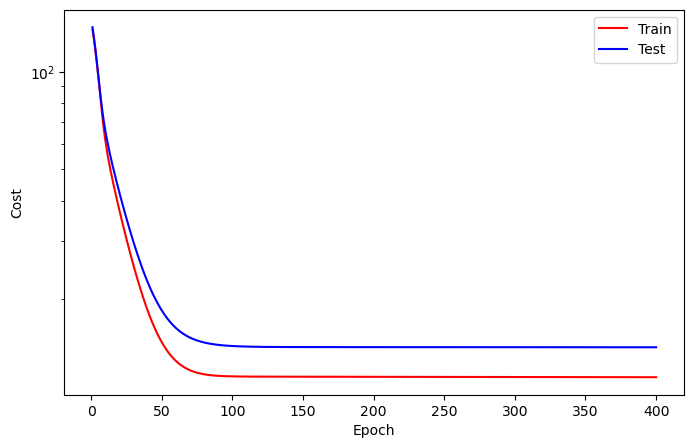

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 11.4602 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 11.4598 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 11.4594 | Test_cost  = 14.1705 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 11.4590 | Test_cost  = 14.1703 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 11.4586 | Test_cost  = 14.1701 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 11.4581 | Test_cost  = 14.1699 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 11.4576 | Test_cost  = 14.1696 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 11.4571 | Test_cost  = 14.1693 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 11.4566 | Test_cost  = 14.1690 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 11.4560 | Test_cost  = 14.1687 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 11.4554 | Test_cost  = 14.1683 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   412
Train_cost  = 11.4548 | Test_cost  = 14.1679 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   413
Train_cost  = 11.4542 | Test_cost  = 14.1675 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   414
Train_cost  = 11.4535 | Test_cost  = 14.1671 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   415
Train_cost  = 11.4528 | Test_cost  = 14.1667 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   416
Train_cost  = 11.4521 | Test_cost  = 14.1662 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   417
Train_cost  = 11.4513 | Test_cost  = 14.1657 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   418
Train_cost  = 11.4505 | Test_cost  = 14.1651 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   419
Train_cost  = 11.4497 | Test_cost  = 14.1645 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   420
Train_cost  = 11.4488 | Test_cost  = 14.1639 | 


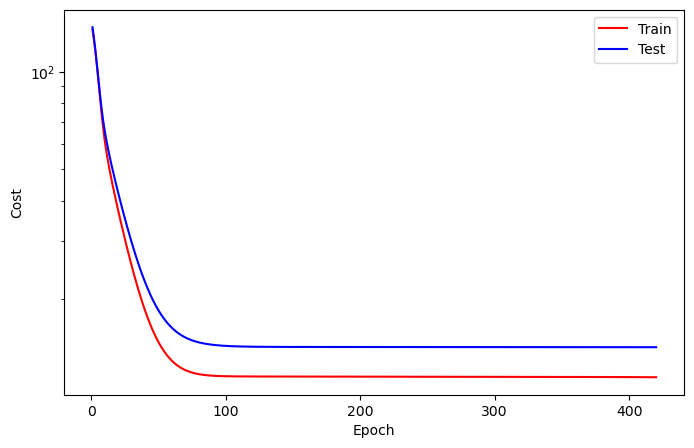

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 11.4478 | Test_cost  = 14.1631 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 11.4467 | Test_cost  = 14.1623 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   423
Train_cost  = 11.4456 | Test_cost  = 14.1613 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   424
Train_cost  = 11.4443 | Test_cost  = 14.1603 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 11.4429 | Test_cost  = 14.1590 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 11.4413 | Test_cost  = 14.1576 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 11.4395 | Test_cost  = 14.1560 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 11.4375 | Test_cost  = 14.1542 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 11.4352 | Test_cost  = 14.1522 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 11.4327 | Test_cost  = 14.1499 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 11.4299 | Test_cost  = 14.1471 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 11.4267 | Test_cost  = 14.1438 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 11.4229 | Test_cost  = 14.1398 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 11.4183 | Test_cost  = 14.1346 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 11.4126 | Test_cost  = 14.1278 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 11.4051 | Test_cost  = 14.1187 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 11.3951 | Test_cost  = 14.1057 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 11.3809 | Test_cost  = 14.0865 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 11.3600 | Test_cost  = 14.0565 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 11.3272 | Test_cost  = 14.0038 | 


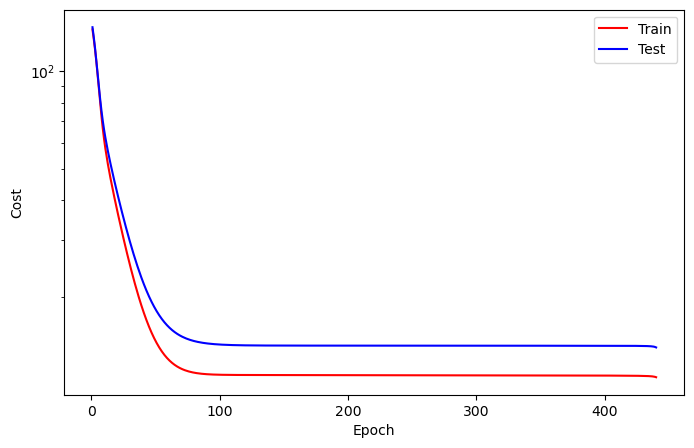

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 11.2697 | Test_cost  = 13.8942 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 11.1504 | Test_cost  = 13.6035 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 10.8328 | Test_cost  = 12.5390 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 9.7892 | Test_cost  = 22.2678 | 
==> EarlyStop patience =  1 | Best test_cost: 12.5390


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 14.4483 | Test_cost  = 12.6104 | 
==> EarlyStop patience =  2 | Best test_cost: 12.5390


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 10.0943 | Test_cost  = 13.2824 | 
==> EarlyStop patience =  3 | Best test_cost: 12.5390


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   447
Train_cost  = 10.7305 | Test_cost  = 13.4826 | 
==> EarlyStop patience =  4 | Best test_cost: 12.5390


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   448
Train_cost  = 10.9469 | Test_cost  = 13.5381 | 
==> EarlyStop patience =  5 | Best test_cost: 12.5390
==> Execute Early Stopping at epoch: 448 | Best test_cost: 12.5390
==> Best model is saved at model/gru


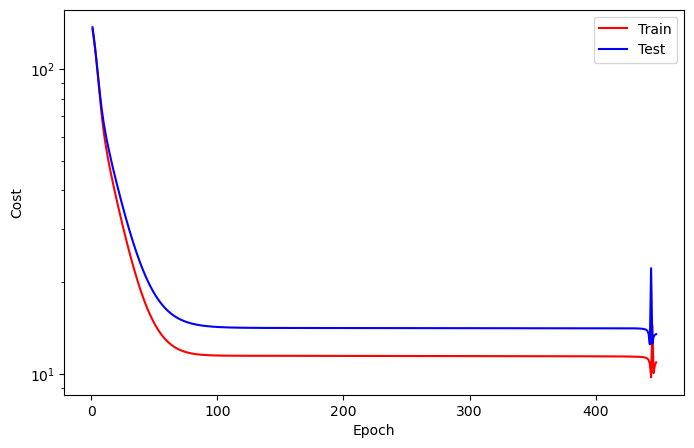

In [17]:
while True:
    train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break



# Forecast

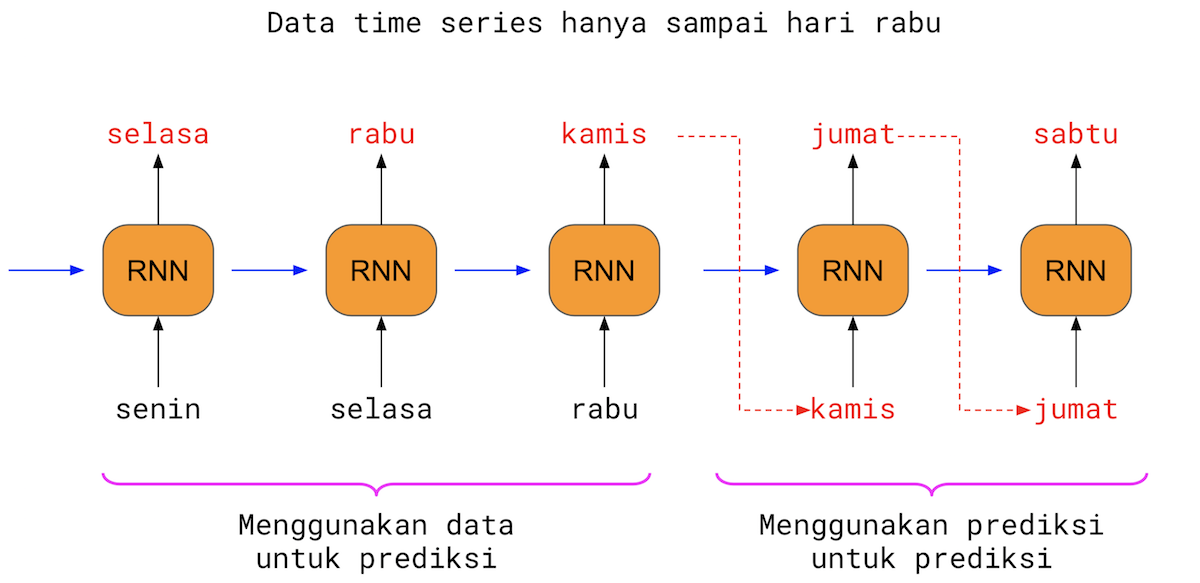

In [18]:
from luwiji.rnn import illustration

illustration.forecast

In [19]:
from utils import data4pred, pred4pred

train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

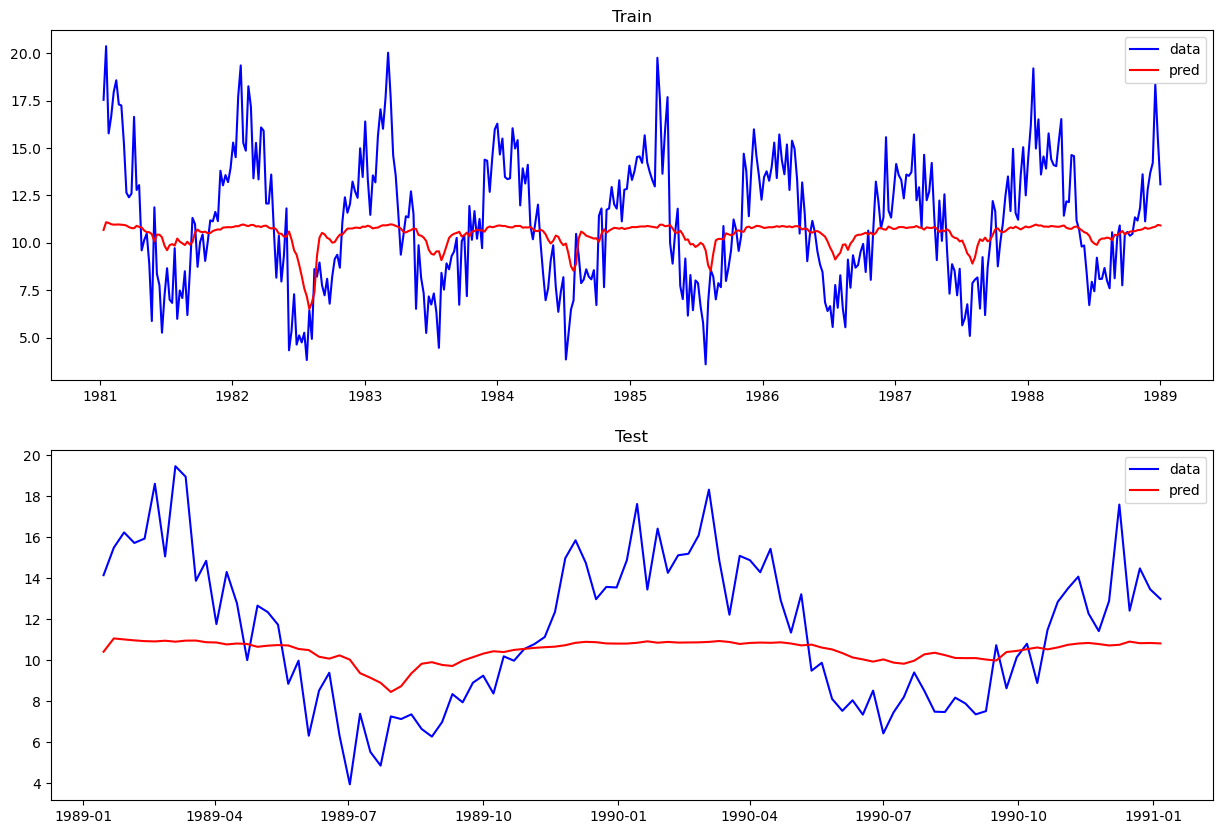

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

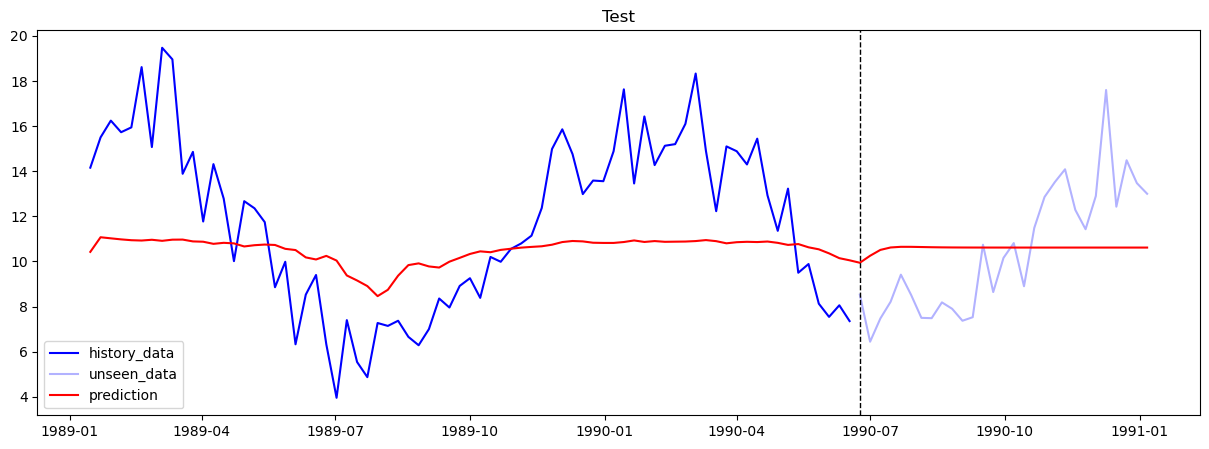

In [21]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

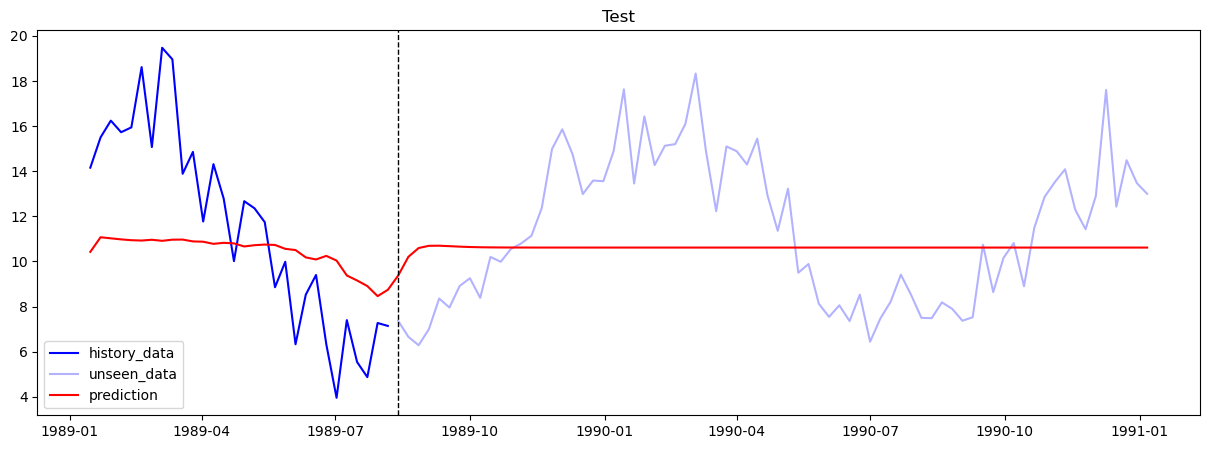

In [22]:
plt.figure(figsize=(15, 5))

pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title('Test')